The MNIST handwritten digit dataset is a popular dataset containing grayscale 28x28 pixel images of handwritten digits. This post explores the use of this dataset to train two neural network models in the identification of handwritten digits.

<!--excerpt-->

### Import Statements

The following libraries will be used for this post:

* `pickle` - for saving the model training histories.
* `matplotlib` - for data plots and visualizations.
* `tensorflow` and `keras` - for training the neural network.
* `sklearn` - for spectral embedding visualization of the results.

In [1]:
%matplotlib notebook
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from sklearn.manifold import SpectralEmbedding

### Load and Plot Sample Data

The following code loads the MNIST numbers data set and plots a sample of 9 digits.

The MNIST dataset is already partitioned into separate training and validation images and labels. The training images and labels will be used to train the models, while the validation images will be used to determine the models accuracy and ensure that the model has not been overfit.

<IPython.core.display.Javascript object>


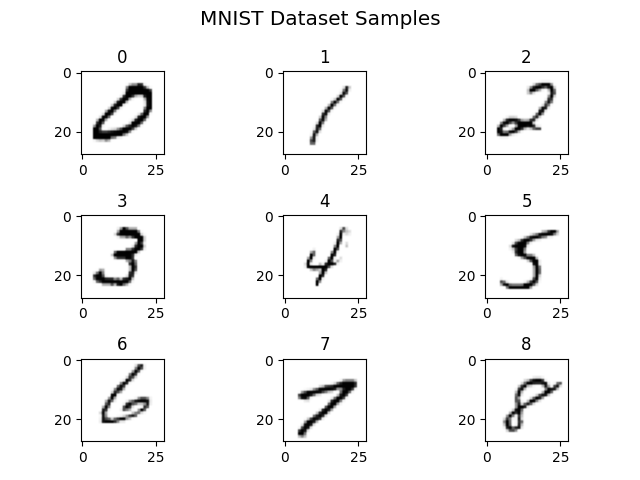

In [2]:
# Load the MNIST data set
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# Plot some sample images from data set
plt.figure()
plt.suptitle("MNIST Dataset Samples", fontsize = 'x-large')
label_indexes = { training_labels[i]: i for i in range(len(training_labels)) }

for i in range(9):
    index = label_indexes[i]
    plt.subplot(3, 3, i + 1)
    plt.title(training_labels[index])
    plt.imshow(training_images[index], cmap = 'Greys')
    
plt.tight_layout()

### Preprocessing Data

Pior to training the models, the image data will need to be normalized to the interval [0, 1]. This is done by dividing by 255, as shown below.

In [3]:
processed_training_images = training_images / 255.0
processed_test_images = test_images / 255.0

One-hot vectors will also need to be created for each label in the data set:

In [4]:
label_set = np.sort(np.unique(training_labels))
training_one_hots = keras.utils.to_categorical(training_labels, len(label_set))
test_one_hots = keras.utils.to_categorical(test_labels, len(label_set))
print("Sample One-Hots:")

for i in range(9):
    print(f"{training_labels[i]}: {training_one_hots[i]}")

Sample One-Hots:
5: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
2: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
3: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


### Model 1: ReLU Activations

The first model will consist of a deep neural network with ReLU activation layers and dropout layers, to prevent overfitting.

In [5]:
model1 = Sequential()
model1.add(Dense(512, input_shape = (28 * 28,), activation = "relu"))           
model1.add(Dropout(0.15))
model1.add(Dense(512, activation = "relu"))
model1.add(Dropout(0.15))
model1.add(Dense(10, activation = "softmax"))
model1.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


The training of the model is performed below, over the course of 5 epochs.

In [6]:
# Reshape data for model
training_vectors1 = processed_training_images.reshape(len(processed_training_images), 28 * 28)
test_vectors1 = processed_test_images.reshape(len(processed_test_images), 28 * 28)

model1_path = "mnist_model1.saved_model"
model1_history_path = "mnist_model1.saved_model_history"

if os.path.exists(model1_path) and os.path.exists(model1_history_path):
    # Load trained model
    model1 = keras.models.load_model(model1_path)
    history1 = pickle.load(open(model1_history_path, "rb"))
else:
    # Train new model
    tensorflow.random.set_seed(12345)
    model1.fit(training_vectors1, training_one_hots,
               batch_size = 64,
               epochs = 5,
               verbose = 1,
               validation_data = (test_vectors1, test_one_hots))
    history1 = model1.history.history
    model1.save(model1_path)
    pickle.dump(history1, open(model1_history_path, "wb"))
    
print(f"Training Accuracy: {history1['accuracy'][-1]:.4}")
print(f"Validation Accuracy: {history1['val_accuracy'][-1]:.4}")

Training Accuracy: 0.985
Validation Accuracy: 0.9801


To ensure that the model has not been overfit, the accuracies on the training and validation sets are plotted below. The training and validation accuracies are both generally increasing, indicating that the model has not been overfit.

<IPython.core.display.Javascript object>


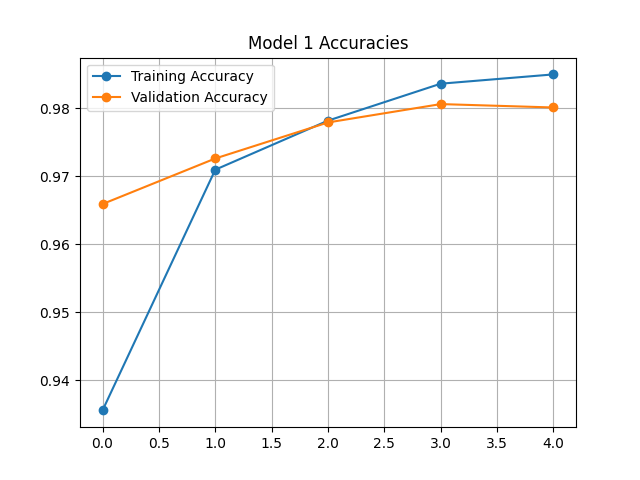

In [7]:
plt.figure()
plt.title("Model 1 Accuracies")
plt.plot(history1["accuracy"], marker = "o", label = "Training Accuracy")
plt.plot(history1["val_accuracy"], marker = "o", label = "Validation Accuracy")
plt.legend()
plt.grid()

### Model 2: Convolutional Network with ReLU Activation

The second model will consist of convolutional activation layers, following by a ReLU activation layer. Dropout layers have also been included to prevent overfitting.

In [8]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape = (28, 28, 1)))
model2.add(Conv2D(32, (3, 3), activation = "relu"))
model2.add(MaxPooling2D(pool_size = (2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128, activation = "relu"))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation = "softmax"))
model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

The training of the model is performed below, over the course of 5 epochs.

In [9]:
# Reshape data for model
training_vectors2 = training_images.reshape(len(training_images), 28, 28, 1)
test_vectors2 = test_images.reshape(len(test_images), 28, 28, 1)

model2_path = "mnist_model2.saved_model"
model2_history_path = "mnist_model2.saved_model_history"

if os.path.exists(model2_path) and os.path.exists(model2_history_path):
    # Load trained model
    model2 = keras.models.load_model(model2_path)
    history2 = pickle.load(open(model2_history_path, "rb"))
else:
    # Train new model
    tensorflow.random.set_seed(12345)
    model2.fit(training_vectors2, training_one_hots,
               batch_size = 64,
               epochs = 5,
               verbose = 1,
               validation_data = (test_vectors2, test_one_hots))
    history2 = model2.history.history
    model2.save(model2_path)
    pickle.dump(history2, open(model2_history_path, "wb"))

print(f"Training Accuracy: {history2['accuracy'][-1]:.4}")
print(f"Validation Accuracy: {history2['val_accuracy'][-1]:.4}")

Training Accuracy: 0.9783
Validation Accuracy: 0.9816


To ensure that the model has not been overfit, the accuracies on the training and validation sets are plotted below. As with Model 1, the training and validation accuracies are both generally increasing, indicating that the model has not been overfit.

<IPython.core.display.Javascript object>


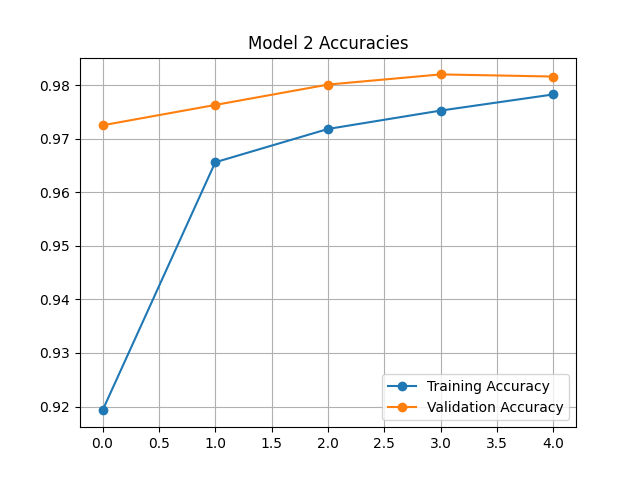

In [10]:
plt.figure()
plt.title("Model 2 Accuracies")
plt.plot(history2["accuracy"], marker = "o", label = "Training Accuracy")
plt.plot(history2["val_accuracy"], marker = "o", label = "Validation Accuracy")
plt.legend()
plt.grid()

### Best Model Selection

The best model will be selected based on which one provided the greatest validation and training accuracies. Based on this criteria, the best model is Model 1. While Model 2 had a higher validation accuracy, its average accuracy was not better than Model 1.

In [11]:
best_model_index = np.argmax([x["val_accuracy"][-1] + x["accuracy"][-1] for x in (history1, history2)])
best_model = (model1, model2)[best_model_index]
history = (history1, history2)[best_model_index]
test_vectors = (test_vectors1, test_vectors2)[best_model_index]

print(f"Best Model: {best_model_index + 1}")
print(f"Training Accuracy: {history['accuracy'][-1]:.4}")
print(f"Validation Accuracy: {history['val_accuracy'][-1]:.4}")

Best Model: 1
Training Accuracy: 0.985
Validation Accuracy: 0.9801


### Best Model Predictions

An example of the best models predictions are plotted below. The mistakes in the incorrect predictions are actually fairly reasonable. Looking at the digits, you can often see where the number could be viewed as the incorrect digit, even if, as a human, you can still discern the difference that the neural network could not.

2021-09-30 15:17:59.155205: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<IPython.core.display.Javascript object>


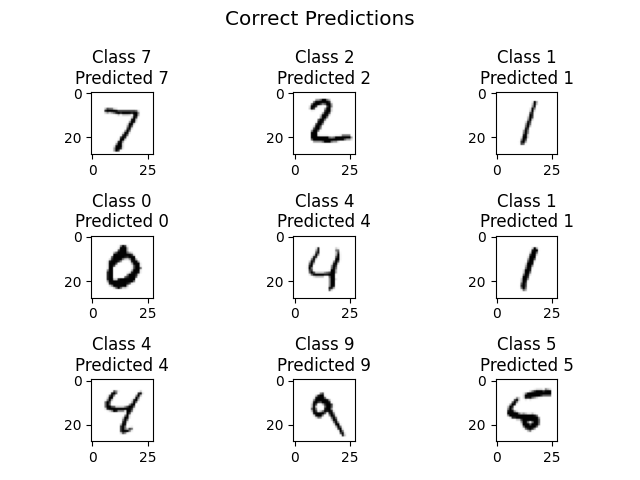

<IPython.core.display.Javascript object>


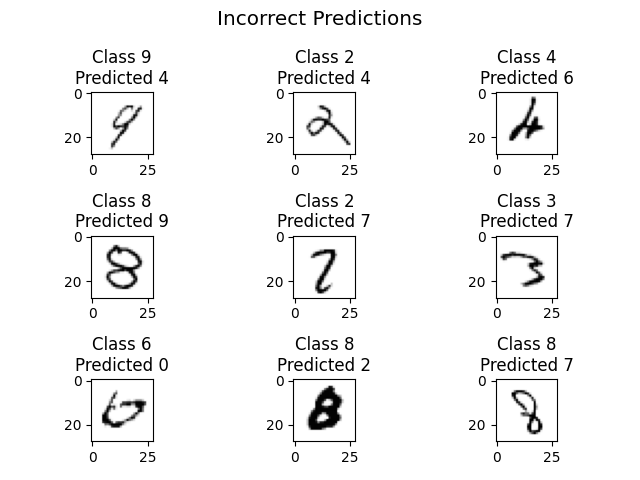

In [12]:
# Predict the class labels
predictions = best_model.predict(test_vectors)
predicted_labels = predictions.argmax(axis = -1)
correct_filter = predicted_labels == test_labels
correct_predictions = np.flatnonzero(correct_filter)
incorrect_predictions = np.flatnonzero(~correct_filter)

# Plot sample of correct predictions
plt.figure()
plt.suptitle("Correct Predictions", fontsize = 'x-large')

for i in range(9):
    index = correct_predictions[i]
    plt.subplot(3, 3, i + 1)
    plt.title(f"Class {test_labels[index]}\nPredicted {predicted_labels[index]}")
    plt.imshow(test_images[index], cmap = 'Greys')
    
plt.tight_layout()

# Plot sample of incorrect predictions
plt.figure()
plt.suptitle("Incorrect Predictions", fontsize = 'x-large')

for i in range(9):
    index = incorrect_predictions[i]
    plt.subplot(3, 3, i + 1)
    plt.title(f"Class {test_labels[index]}\nPredicted {predicted_labels[index]}")
    plt.imshow(test_images[index], cmap = 'Greys')

plt.tight_layout()

### Label Percent Correct

From the calculated label percent correct, shown below, the model is relatively consistent in its prediction accuracy for different labels.

Label Percent Correct:
0: 99.29%
1: 98.77%
2: 97.58%
3: 97.62%
4: 98.17%
5: 98.09%
6: 98.64%
7: 97.37%
8: 96.92%
9: 97.62%


<IPython.core.display.Javascript object>


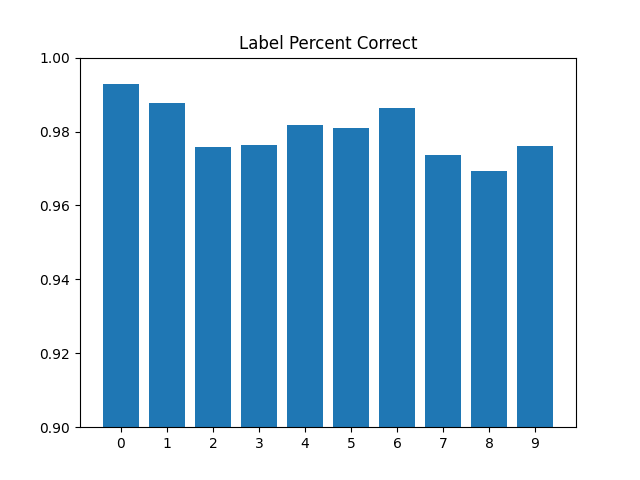

In [13]:
print("Label Percent Correct:")
labels_correct = []

for i in label_set:
    label_filter = i == test_labels
    count = np.sum(label_filter)
    correct = np.sum(correct_filter & label_filter)
    ratio = correct / float(count)
    labels_correct.append(ratio)
    print(f"{i}: {ratio:.2%}")
    
plt.figure()
plt.title("Label Percent Correct")
plt.xticks(range(10))
plt.ylim(0.9, 1)
plt.bar(label_set, labels_correct);

### Confusion Matrix

The confusion matrix is shown below. The only significant items of note are that digits 4 and 9 and digits 2 and 7 appear to have higher incorrect predictions between them than other digits.

In [14]:
confusion_matrix = tensorflow.math.confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
tf.Tensor(
[[ 973    1    1    1    0    0    1    0    2    1]
 [   0 1121    2    1    0    1    2    0    8    0]
 [   3    0 1007    1    2    0    2    8    9    0]
 [   0    0    4  986    0    6    0    5    1    8]
 [   2    0    1    0  964    0    5    1    0    9]
 [   2    0    0    5    2  875    2    1    4    1]
 [   3    2    0    1    3    1  945    0    3    0]
 [   1    2   10    1    3    0    0 1001    2    8]
 [   4    0    4    4    4    2    2    3  944    7]
 [   1    2    0    2   15    1    0    2    1  985]], shape=(10, 10), dtype=int32)


### Spectral Embedding

The spectral embedding provides a graphical representation of the similarity between images. Based on the below graph, it is likely that there will be confusion between digits 4, 7, and 9 due to their close clustering towards the bottom. Furthermore, 3, 5, and 8 show some overlap towards the middle. Digits 0 and 1 are plotted fairly distinctly from the other digits, indicating that they will likely be the easiest to identify. Since these two digits had the highest prediction percent correct of all of the digits, this is consistent with the results of our model.

<IPython.core.display.Javascript object>


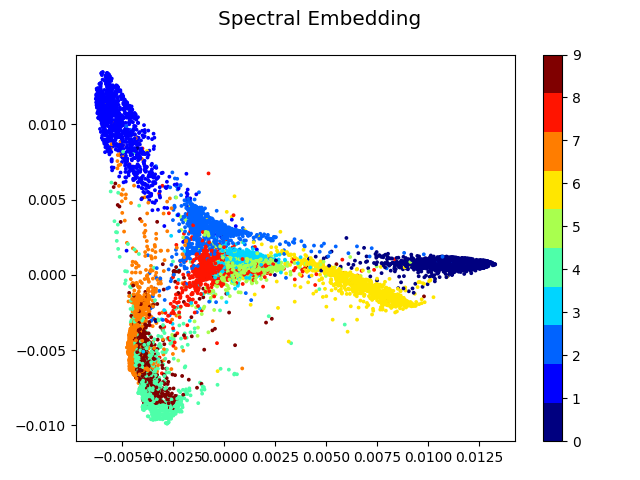

In [15]:
spectral_model = SpectralEmbedding(n_neighbors = 5)
projections = spectral_model.fit_transform(test_vectors1)

fig = plt.figure()
fig.suptitle("Spectral Embedding", fontsize="x-large")
ax = fig.add_subplot(111)
scatter = ax.scatter(projections[:,0], projections[:,1],
                     s = 3,
                     c = test_labels,
                     cmap = plt.cm.get_cmap("jet", 10))

color_bar = fig.colorbar(scatter)
fig.tight_layout()